# Simple DNN 
Analyzing effect of "class_weight" parameter in Xtohh2000 signal region 2 tags.
* check csv files with signal or label (??)

In [1]:
import numpy as np
import pandas as pd
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import (classification_report, recall_score,  precision_score, f1_score, roc_auc_score,
        precision_recall_curve, make_scorer, confusion_matrix, accuracy_score, roc_curve, average_precision_score)
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras import backend as K
from keras.callbacks import TensorBoard

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sns

Using TensorFlow backend.
/Users/rpezoa/opt/anaconda3/envs/my_root_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/rpezoa/opt/anaconda3/envs/my_root_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/rpezoa/opt/anaconda3/envs/my_root_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [25]:
def get_training_set_with_weights(X,y,t_s):
    # The las column has the weights
    print("-->", X.shape)
    X_train_t, X_test_t, y_train, y_test = train_test_split(X, y, test_size=t_s)

    # removing the weight column
    X_train = X_train_t[:,0:-1]
    X_test = X_test_t[:,0:-1]

    print("X_train.shape:", X_train.shape, "X_test.shape:",X_test.shape)
    train_weights = X_train_t[:,-1]
    test_weights = X_test_t[:,-1]

    return X_train, X_test, y_train, y_test, train_weights, test_weights

def data_norm_minmax_with_weights(X,y,pesos):
    min_max_scaler = preprocessing.MinMaxScaler()
    X_scaled = min_max_scaler.fit_transform(X)
    pesos = np.reshape(pesos,(pesos.shape[0],1))
    print(X_scaled.shape, pesos.shape)

    # X_temp with the EventsWeights, which are not considered for scaling
    # but necessary for getting EventsWeights separated by training and
    # testing, using train_test_split()
    X_temp = np.concatenate((X_scaled,pesos[:]), axis=1)
    print(X_temp.shape)
    return X_temp

    
def dnn(X_train, y_train, n_input,withWeight=True, train_weights=[]):
    print("----->",train_weights.shape)
    def f1_(y_true, y_pred):
        def recall_(y_true, y_pred):
            """Recall metric.
            Only computes a batch-wise average of recall.
            Computes the recall, a metric for multi-label classification of
            how many relevant items are selected.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

        def precision_(y_true, y_pred):
            """Precision metric.
            Only computes a batch-wise average of precision.
            Computes the precision, a metric for multi-label classification of
            how many selected items are relevant.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision

        precision = precision_(y_true, y_pred)
        recall = recall_(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

    # Architecture
    classifier = Sequential()
        #First Hidden Layer
    classifier.add(Dense(100, activation='relu', kernel_initializer='uniform', input_dim=n_input))
    classifier.add(Dropout(rate= 0.1))
    #Second  Hidden Layer
    classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
    classifier.add(Dropout(rate= 0.1))
    #Third  Hidden Layer
    classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
    classifier.add(Dropout(rate= 0.1))
    #Fourth Hidden Layer
    classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
    classifier.add(Dropout(rate= 0.1))
    #Fifth Hidden Layer
    classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
    classifier.add(Dropout(rate= 0.1))
    #Output Layer
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer='uniform'))


    #Training
    classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =[f1_])

    #Fitting the data to the training dataset
    if withWeight:
        classifier.fit(X_train,y_train, batch_size=100, epochs=150, sample_weight=train_weights)
    else:
        classifier.fit(X_train,y_train, batch_size=100, epochs=150)

    return classifier


In [26]:
def filter_per_region_tag(df,signal_region, tag):
    df = df[(df['m_region']==signal_region) & (df['m_FJNbtagJets']==tag)]
    return df
 
def set_label(row):
    if 'Xtohh' + signal_type in row['sample']:
        return 1
    else:
        return 0

In [27]:
signal_type = "2000"
signal_file = "../processed_data/Xtohh{0}.csv".format(signal_type)
df = pd.read_csv(signal_file)

print(df.columns)

df = filter_per_region_tag(df, "SR",2)
print(df["m_region"].value_counts())
print(df["m_FJNbtagJets"].value_counts())



Index(['sample', 'EventWeightNoXSec', 'EventWeight', 'EventNumber', 'm_region',
       'm_FJNbtagJets', 'm_AntiBTag', 'm_AntiTauTag', 'm_FJpt', 'm_FJeta',
       'm_FJphi', 'm_FJm', 'm_DTpt', 'm_DTeta', 'm_DTphi', 'm_DTm',
       'm_DTpt_Eff', 'm_DTeta_Eff', 'm_DTphi_Eff', 'm_DTm_Eff',
       'm_DTpt_ConEff', 'm_DTeta_ConEff', 'm_DTphi_ConEff', 'm_DTm_ConEff',
       'm_DTpt_ConVis', 'm_DTeta_ConVis', 'm_DTphi_ConVis', 'm_DTm_ConVis',
       'm_dPhiFTwDT', 'm_dRFJwDT', 'm_dPhiDTwMET', 'm_MET', 'm_hhm',
       'm_bbttpt', 'm_hhm_Coll', 'm_hhm_Eff', 'm_hhm_ConEff', 'm_hhm_ConVis'],
      dtype='object')
SR    8737
Name: m_region, dtype: int64
2    8737
Name: m_FJNbtagJets, dtype: int64


## without label

In [28]:
df

,sample,EventWeightNoXSec,EventWeight,EventNumber,m_region,m_FJNbtagJets,m_AntiBTag,m_AntiTauTag,m_FJpt,m_FJeta,...,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt,m_hhm_Coll,m_hhm_Eff,m_hhm_ConEff,m_hhm_ConVis
0,Xtohh2000_Hw,0.008301,0.001020,46746,SR,2,3,0,885.55927,0.104927,...,3.105514,3.216185,-0.192894,237.887240,1631.6702,263.697630,-999.0,1896.5974,1193.06690,1973.7532
4,Xtohh2000_Hw,0.009094,0.001117,47033,SR,2,2,0,855.69904,0.313113,...,2.779941,2.848176,-0.019178,485.033330,1293.4028,463.512360,-999.0,1832.4620,1597.40980,1934.0298
15,Xtohh2000_Hw,0.007525,0.000925,47483,SR,2,3,0,552.47845,-0.702952,...,3.122708,3.566858,-0.742126,104.559220,1659.8483,80.008150,-999.0,1759.5939,1056.44380,2125.3684
18,Xtohh2000_Hw,0.009422,0.001158,42700,SR,2,2,0,525.10590,-0.941433,...,3.111627,3.282524,-0.130256,166.607220,1075.3092,109.524925,-999.0,1262.3474,1561.97060,1574.2820
20,Xtohh2000_Hw,0.009115,0.001120,43588,SR,2,3,0,916.44147,-0.683193,...,3.079124,3.084862,0.416606,167.350300,1595.7611,244.283460,-999.0,1807.4701,1296.02860,1838.6957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101826,fakes,-0.005359,-0.000055,14761375,SR,2,2,2,619.94476,-1.530844,...,3.034102,4.098625,-0.280388,286.408970,2155.6992,207.416440,-999.0,2464.0880,1264.09350,3769.2827
102176,fakes,-0.007917,-0.000081,10950484,SR,2,2,2,611.34870,-0.871494,...,3.033280,3.183265,-0.295021,169.082120,1239.1935,155.007490,-999.0,1431.8264,1335.67540,1390.9071
102488,fakes,-0.005557,-0.000057,13567747,SR,2,2,2,777.56586,1.187897,...,2.463912,2.519432,0.347042,77.403076,1145.7860,516.615660,-999.0,1311.9071,747.07306,1560.4794
103066,fakes,-0.048060,-0.000178,5199226,SR,2,2,2,353.45984,0.976739,...,3.131047,3.131053,0.771418,42.421673,803.4093,89.133310,-999.0,862.0342,710.66235,1195.4740


In [29]:
# Adding labels, 0->background, 1-> signal
df["label"] = None
df["label"] = df.apply(set_label, axis=1)

pesos = df["EventWeight"].values

# Removing not relevant features for classification process
not_features = ['sample', 'm_region', 'm_FJNbtagJets', 
                'EventWeightNoXSec']
df.drop(not_features, axis=1, inplace=True)
feature_cols = df.columns.values
print("\nVariables after removing\n", feature_cols)


Variables after removing
 ['EventWeight' 'EventNumber' 'm_AntiBTag' 'm_AntiTauTag' 'm_FJpt'
 'm_FJeta' 'm_FJphi' 'm_FJm' 'm_DTpt' 'm_DTeta' 'm_DTphi' 'm_DTm'
 'm_DTpt_Eff' 'm_DTeta_Eff' 'm_DTphi_Eff' 'm_DTm_Eff' 'm_DTpt_ConEff'
 'm_DTeta_ConEff' 'm_DTphi_ConEff' 'm_DTm_ConEff' 'm_DTpt_ConVis'
 'm_DTeta_ConVis' 'm_DTphi_ConVis' 'm_DTm_ConVis' 'm_dPhiFTwDT'
 'm_dRFJwDT' 'm_dPhiDTwMET' 'm_MET' 'm_hhm' 'm_bbttpt' 'm_hhm_Coll'
 'm_hhm_Eff' 'm_hhm_ConEff' 'm_hhm_ConVis' 'label']


In [30]:
df

,EventWeight,EventNumber,m_AntiBTag,m_AntiTauTag,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,...,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt,m_hhm_Coll,m_hhm_Eff,m_hhm_ConEff,m_hhm_ConVis,label
0,0.001020,46746,3,0,885.55927,0.104927,-2.448576,127604.300,623.22710,-0.731510,...,3.216185,-0.192894,237.887240,1631.6702,263.697630,-999.0,1896.5974,1193.06690,1973.7532,1
4,0.001117,47033,2,0,855.69904,0.313113,-1.859287,122862.900,449.37933,-0.306591,...,2.848176,-0.019178,485.033330,1293.4028,463.512360,-999.0,1832.4620,1597.40980,1934.0298,1
15,0.000925,47483,3,0,552.47845,-0.702952,-2.549875,109091.670,631.70496,1.020756,...,3.566858,-0.742126,104.559220,1659.8483,80.008150,-999.0,1759.5939,1056.44380,2125.3684,1
18,0.001158,42700,2,0,525.10590,-0.941433,-1.130162,82382.280,416.48105,0.103909,...,3.282524,-0.130256,166.607220,1075.3092,109.524925,-999.0,1262.3474,1561.97060,1574.2820,1
20,0.001120,43588,3,0,916.44147,-0.683193,1.804695,115936.010,677.16440,-0.495132,...,3.084862,0.416606,167.350300,1595.7611,244.283460,-999.0,1807.4701,1296.02860,1838.6957,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101826,-0.000055,14761375,2,2,619.94476,-1.530844,2.352461,93778.555,419.90290,1.224686,...,4.098625,-0.280388,286.408970,2155.6992,207.416440,-999.0,2464.0880,1264.09350,3769.2827,0
102176,-0.000081,10950484,2,2,611.34870,-0.871494,-0.264761,227763.140,467.55270,0.094108,...,3.183265,-0.295021,169.082120,1239.1935,155.007490,-999.0,1431.8264,1335.67540,1390.9071,0
102488,-0.000057,13567747,2,2,777.56586,1.187897,-2.571395,48316.727,434.83230,1.713899,...,2.519432,0.347042,77.403076,1145.7860,516.615660,-999.0,1311.9071,747.07306,1560.4794,0
103066,-0.000178,5199226,2,2,353.45984,0.976739,-3.131807,79305.380,442.49554,0.970799,...,3.131053,0.771418,42.421673,803.4093,89.133310,-999.0,862.0342,710.66235,1195.4740,0


In [31]:
df_signal = df[df["label"]==1]
n_signal = len(df_signal)
print("# signal:",n_signal)
df_back = df[df["label"]==0]
n_back=len(df_back)
print("# background:",n_back)

# signal: 8560
# background: 177


In [32]:
weights_signal = df_signal["EventWeight"].values.sum()
weights_back = df_back["EventWeight"].values.sum()
den_signal = weights_signal/(weights_signal + weights_back)
den_back = weights_back/(weights_signal + weights_back)
print("% signal:", n_signal/(n_signal+n_back))
print("% background:", n_back/(n_signal+n_back))

% signal: 0.9797413299759643
% background: 0.02025867002403571


## Seleceting some features

In [33]:
df2 = df[['m_FJpt', 'm_FJeta', 'm_FJphi', 'm_FJm',
       'm_DTpt', 'm_DTeta', 'm_DTphi', 'm_DTm', 'm_dPhiFTwDT', 'm_dRFJwDT',
       'm_dPhiDTwMET', 'm_MET', 'm_hhm', 'm_bbttpt', "label"]]


In [34]:
df2

,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt,label
0,885.55927,0.104927,-2.448576,127604.300,623.22710,-0.731510,0.656939,85368.720,3.105514,3.216185,-0.192894,237.887240,1631.6702,263.697630,1
4,855.69904,0.313113,-1.859287,122862.900,449.37933,-0.306591,0.920655,55754.656,2.779941,2.848176,-0.019178,485.033330,1293.4028,463.512360,1
15,552.47845,-0.702952,-2.549875,109091.670,631.70496,1.020756,0.610602,76213.550,3.122708,3.566858,-0.742126,104.559220,1659.8483,80.008150,1
18,525.10590,-0.941433,-1.130162,82382.280,416.48105,0.103909,1.981465,58332.793,3.111627,3.282524,-0.130256,166.607220,1075.3092,109.524925,1
20,916.44147,-0.683193,1.804695,115936.010,677.16440,-0.495132,-1.274429,94135.960,3.079124,3.084862,0.416606,167.350300,1595.7611,244.283460,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101826,619.94476,-1.530844,2.352461,93778.555,419.90290,1.224686,-0.896622,40863.637,3.034102,4.098625,-0.280388,286.408970,2155.6992,207.416440,0
102176,611.34870,-0.871494,-0.264761,227763.140,467.55270,0.094108,2.768519,98680.410,3.033280,3.183265,-0.295021,169.082120,1239.1935,155.007490,0
102488,777.56586,1.187897,-2.571395,48316.727,434.83230,1.713899,-0.107483,67534.984,2.463912,2.519432,0.347042,77.403076,1145.7860,516.615660,0
103066,353.45984,0.976739,-3.131807,79305.380,442.49554,0.970799,0.020331,56492.152,3.131047,3.131053,0.771418,42.421673,803.4093,89.133310,0


In [35]:
X = df2.values
X = X[:,0:-1]
# Targets
y = df2['label'].values

print("X.shape", X.shape, "y.shape", y.shape)

X.shape (8737, 14) y.shape (8737,)


In [36]:
X_temp = data_norm_minmax_with_weights(X,y,pesos)

(8737, 14) (8737, 1)
(8737, 15)


In [37]:
X_train, X_test, y_train, y_test, train_weights, test_weights = get_training_set_with_weights(X_temp, y, 0.6)


print("Training size:",X_train.shape[0])
print("Test size:", X_test.shape[0])
values, counts = np.unique(y, return_counts=True)
print("Signal amount:", counts[1],",", round(counts[1]/y.shape[0], 2),"%")
print("Background amount:", counts[0],",", round(counts[0]/y.shape[0], 2),"%")

--> (8737, 15)
X_train.shape: (3494, 14) X_test.shape: (5243, 14)
Training size: 3494
Test size: 5243
Signal amount: 8560 , 0.98 %
Background amount: 177 , 0.02 %


In [38]:
def print_class_dist():
    values_s, count_s = np.unique(y_train, return_counts=True)
    print("Signal training events:", count_s[1],",", round(count_s[1]/X_train.shape[0], 2),"%")
    print("Background training events:", count_s[0],",", round(count_s[0]/X_train.shape[0],2),"%")
    values_b, count_b = np.unique(y_test, return_counts=True)
    print("Signal testing events:", count_b[1],",", round(count_b[1]/X_test.shape[0],2),"%")
    print("Background testing events:", count_b[0],",", round(count_b[0]/X_test.shape[0],2),"%")
    
print_class_dist()

Signal training events: 3425 , 0.98 %
Background training events: 69 , 0.02 %
Signal testing events: 5135 , 0.98 %
Background testing events: 108 , 0.02 %


In [39]:
n_train_events, n_features = X_train.shape

# Simple DNN Unweighted 

In [40]:
classifier = dnn(X_train, y_train, n_features,False,train_weights)

-----> (3494,)
Epoch 1/150
3494/3494 [==============================] - 2s 510us/step - loss: 0.4995 - f1_: 0.9627
Epoch 2/150
3494/3494 [==============================] - 0s 118us/step - loss: 0.1054 - f1_: 0.9900
Epoch 3/150
3494/3494 [==============================] - 0s 118us/step - loss: 0.0937 - f1_: 0.9900
Epoch 4/150
3494/3494 [==============================] - 0s 111us/step - loss: 0.0889 - f1_: 0.9900
Epoch 5/150
3494/3494 [==============================] - 0s 106us/step - loss: 0.0878 - f1_: 0.9899
Epoch 6/150
3494/3494 [==============================] - 1s 160us/step - loss: 0.0855 - f1_: 0.9900
Epoch 7/150
3494/3494 [==============================] - 1s 154us/step - loss: 0.0830 - f1_: 0.9900
Epoch 8/150
3494/3494 [==============================] - 1s 205us/step - loss: 0.0770 - f1_: 0.9900
Epoch 9/150
3494/3494 [==============================] - 0s 108us/step - loss: 0.0749 - f1_: 0.9900
Epoch 10/150
3494/3494 [==============================] - 0s 143us/step - loss: 0.073

3494/3494 [==============================] - 0s 105us/step - loss: 0.0439 - f1_: 0.9941
Epoch 83/150
3494/3494 [==============================] - 0s 104us/step - loss: 0.0456 - f1_: 0.9940
Epoch 84/150
3494/3494 [==============================] - 0s 103us/step - loss: 0.0449 - f1_: 0.9940
Epoch 85/150
3494/3494 [==============================] - 0s 104us/step - loss: 0.0457 - f1_: 0.9940
Epoch 86/150
3494/3494 [==============================] - 0s 103us/step - loss: 0.0488 - f1_: 0.9942
Epoch 87/150
3494/3494 [==============================] - 0s 103us/step - loss: 0.0434 - f1_: 0.9937
Epoch 88/150
3494/3494 [==============================] - 0s 104us/step - loss: 0.0400 - f1_: 0.9946
Epoch 89/150
3494/3494 [==============================] - 0s 103us/step - loss: 0.0386 - f1_: 0.9952
Epoch 90/150
3494/3494 [==============================] - 0s 104us/step - loss: 0.0414 - f1_: 0.9946
Epoch 91/150
3494/3494 [==============================] - 0s 105us/step - loss: 0.0359 - f1_: 0.9952
Epo

In [52]:
def get_report(classifier, X_test, y_test,):
    
    y_pred_prob = classifier.predict(X_test)
    y_pred = (y_pred_prob>0.4)

    cp = classification_report(y_test,y_pred)
    print(cp)

    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    return y_pred, y_pred_prob, cm

In [53]:
y_train_pred, y_train_pred_probm, cm_tr_1 = get_report(classifier,  X_train, y_train)


              precision    recall  f1-score   support

           0       0.98      0.81      0.89        69
           1       1.00      1.00      1.00      3425

   micro avg       1.00      1.00      1.00      3494
   macro avg       0.99      0.91      0.94      3494
weighted avg       1.00      1.00      1.00      3494

[[  56   13]
 [   1 3424]]


In [54]:
y_pred_test, y_pred_prob, cm_test_1 = get_report(classifier,X_test, y_test)


              precision    recall  f1-score   support

           0       0.71      0.51      0.59       108
           1       0.99      1.00      0.99      5135

   micro avg       0.99      0.99      0.99      5243
   macro avg       0.85      0.75      0.79      5243
weighted avg       0.98      0.99      0.98      5243

[[  55   53]
 [  22 5113]]


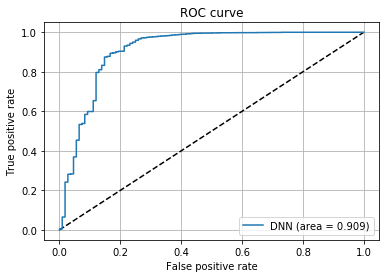

In [55]:
def plot_roc(y_pred_prob, y_test,s):
    y_pred_prob = y_pred_prob[:,-1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    roc_auc_s = roc_auc_score(y_test, y_pred_prob)

    #https://github.com/Tony607/ROC-Keras/blob/master/ROC-Keras.ipynb
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label= s + ' (area = {:.3f})'.format(roc_auc_s))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
        
plot_roc(y_pred_prob, y_test, "DNN")

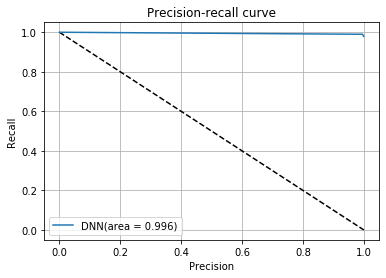

In [56]:

def plot_pr(y_pred_prob, y_test, y_pred, s):
    y_pred_prob = y_pred_prob[:,-1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    prec_rec_auc = average_precision_score(y_test, y_pred_prob)

    plt.figure()
    plt.plot([0, 1], [1, 0], 'k--')
    plt.plot(recall, precision, label= s + '(area = {:.3f})'.format(prec_rec_auc))
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-recall curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

plot_pr(y_pred_prob, y_test, y_pred_test, "DNN")

# Simple DNN Weighted

In [57]:
classifier_2 = dnn(X_train, y_train, n_features,True,train_weights)

-----> (3494,)
Epoch 1/150
3494/3494 [==============================] - 2s 499us/step - loss: 9.1423e-04 - f1_: 0.9677
Epoch 2/150
3494/3494 [==============================] - 0s 106us/step - loss: 7.9269e-04 - f1_: 0.9900
Epoch 3/150
3494/3494 [==============================] - 0s 105us/step - loss: 6.2782e-04 - f1_: 0.9900
Epoch 4/150
3494/3494 [==============================] - 0s 106us/step - loss: 6.2297e-04 - f1_: 0.9900
Epoch 5/150
3494/3494 [==============================] - 0s 106us/step - loss: 6.3240e-04 - f1_: 0.9899
Epoch 6/150
3494/3494 [==============================] - 0s 110us/step - loss: 5.6842e-04 - f1_: 0.9900
Epoch 7/150
3494/3494 [==============================] - 0s 107us/step - loss: 4.8816e-04 - f1_: 0.9900
Epoch 8/150
3494/3494 [==============================] - 0s 105us/step - loss: 4.2309e-04 - f1_: 0.9900
Epoch 9/150
3494/3494 [==============================] - 0s 106us/step - loss: 3.3864e-04 - f1_: 0.9900
Epoch 10/150
3494/3494 [=========================

Epoch 79/150
3494/3494 [==============================] - 0s 104us/step - loss: 3.8857e-05 - f1_: 0.9903
Epoch 80/150
3494/3494 [==============================] - 0s 106us/step - loss: -1.6941e-05 - f1_: 0.9897
Epoch 81/150
3494/3494 [==============================] - 0s 105us/step - loss: -1.7555e-04 - f1_: 0.9862
Epoch 82/150
3494/3494 [==============================] - 0s 106us/step - loss: 7.2446e-05 - f1_: 0.9853
Epoch 83/150
3494/3494 [==============================] - 0s 106us/step - loss: 9.8601e-05 - f1_: 0.9677
Epoch 84/150
3494/3494 [==============================] - 0s 106us/step - loss: -6.2484e-05 - f1_: 0.9893
Epoch 85/150
3494/3494 [==============================] - 0s 106us/step - loss: -6.4818e-04 - f1_: 0.9732
Epoch 86/150
3494/3494 [==============================] - 0s 106us/step - loss: -7.8056e-04 - f1_: 0.9693
Epoch 87/150
3494/3494 [==============================] - 0s 105us/step - loss: 0.0020 - f1_: 0.9435
Epoch 88/150
3494/3494 [==============================

In [58]:
y_train_pred, y_train_pred_prob, cm_tr_2 = get_report(classifier_2,  X_train, y_train)



              precision    recall  f1-score   support

           0       0.10      0.70      0.17        69
           1       0.99      0.87      0.93      3425

   micro avg       0.87      0.87      0.87      3494
   macro avg       0.55      0.78      0.55      3494
weighted avg       0.98      0.87      0.91      3494

[[  48   21]
 [ 442 2983]]


In [59]:


y_pred_test, y_pred_prob, cm_test_2 = get_report(classifier_2,X_test, y_test)



              precision    recall  f1-score   support

           0       0.10      0.72      0.18       108
           1       0.99      0.87      0.93      5135

   micro avg       0.87      0.87      0.87      5243
   macro avg       0.55      0.80      0.55      5243
weighted avg       0.97      0.87      0.91      5243

[[  78   30]
 [ 676 4459]]


In [60]:
cm_test_1

array([[  55,   53],
       [  22, 5113]])

In [61]:
cm_test_2

array([[  78,   30],
       [ 676, 4459]])

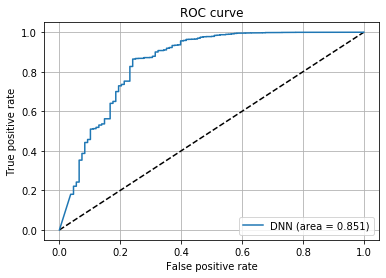

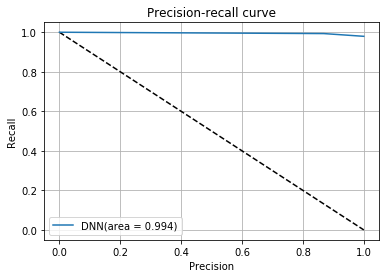

In [62]:
plot_roc(y_pred_prob, y_test, "DNN")
plot_pr(y_pred_prob, y_test, y_pred_test, "DNN")